# The GRAND WATERSHED PIPELINE

This notebook is designed to provide a parameterized pipeline for Watershed Transformations.  
Hopefully this wil simplify experimentation with different parameters, filtering functions,  
and input images.

In [2]:
from skimage import exposure
from skimage import filters
from skimage import io
from skimage import color
from skimage import feature
from skimage import segmentation
from skimage import morphology
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
"""
Parameters
"""
# on/off switch for inline images
SHOW_IMAGES = True

# path to input image
# using pre-cropped and pre-equalized band_contrast_image as input
ROOT_IMAGE_FILE = '../images/ipf_x_abs_image.png'
# ROOT_IMAGE_FILE = 'band_contrast_crop_equalize.png'

# on/off switch for histogram equalization of root_image
EQUALIZE_HIST = True

# rank order filter box size
RO_DIMENSIONS = 7

# local thresholding block size
LT_BLOCK_SIZE = 15


root_image: (1762, 2828) float64


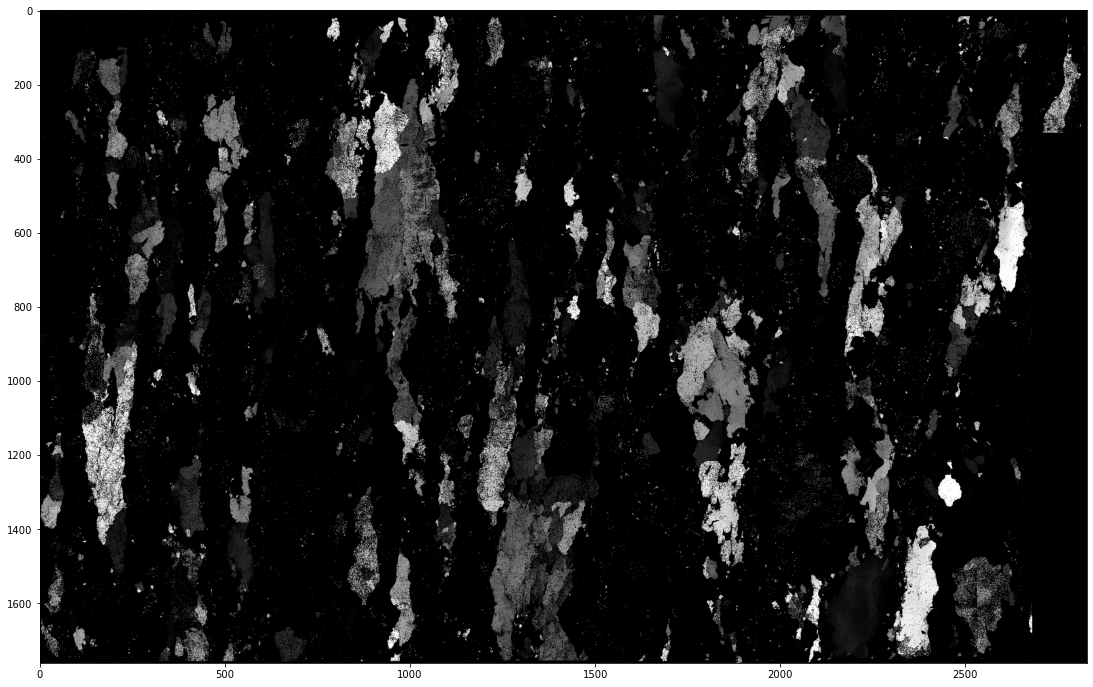

In [4]:
"""
Initial Image: root_image
Optional histogram equalization
"""
root_image = io.imread(ROOT_IMAGE_FILE, as_gray=True)

if EQUALIZE_HIST:
    root_image = exposure.equalize_hist(root_image)

print(f"root_image: {root_image.shape} {root_image.dtype}")

if SHOW_IMAGES:
    fig, axs = plt.subplots(1, figsize=(24, 12))
    axs.imshow(root_image, cmap='gray')


rank_filtered: (1762, 2828) float64


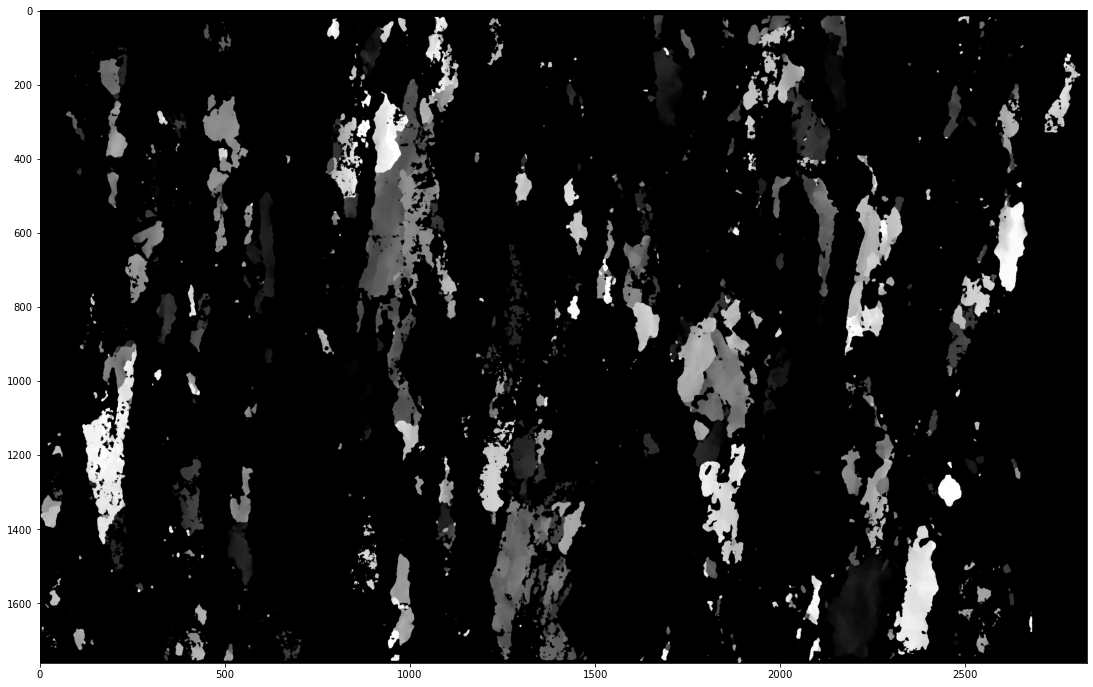

In [5]:
"""
Median Rank Filtering: rank_filtered
"""
median_rank = (RO_DIMENSIONS * RO_DIMENSIONS) // 2
rank_filtered = ndi.rank_filter(
    root_image, median_rank, size=(RO_DIMENSIONS, RO_DIMENSIONS)
)

print(f"rank_filtered: {rank_filtered.shape} {rank_filtered.dtype}")

if SHOW_IMAGES:
    fig, axs = plt.subplots(1, figsize=(24, 12))
    axs.imshow(rank_filtered, cmap='gray')


local_thresh: (1762, 2828) float64
mask: (1762, 2828) bool


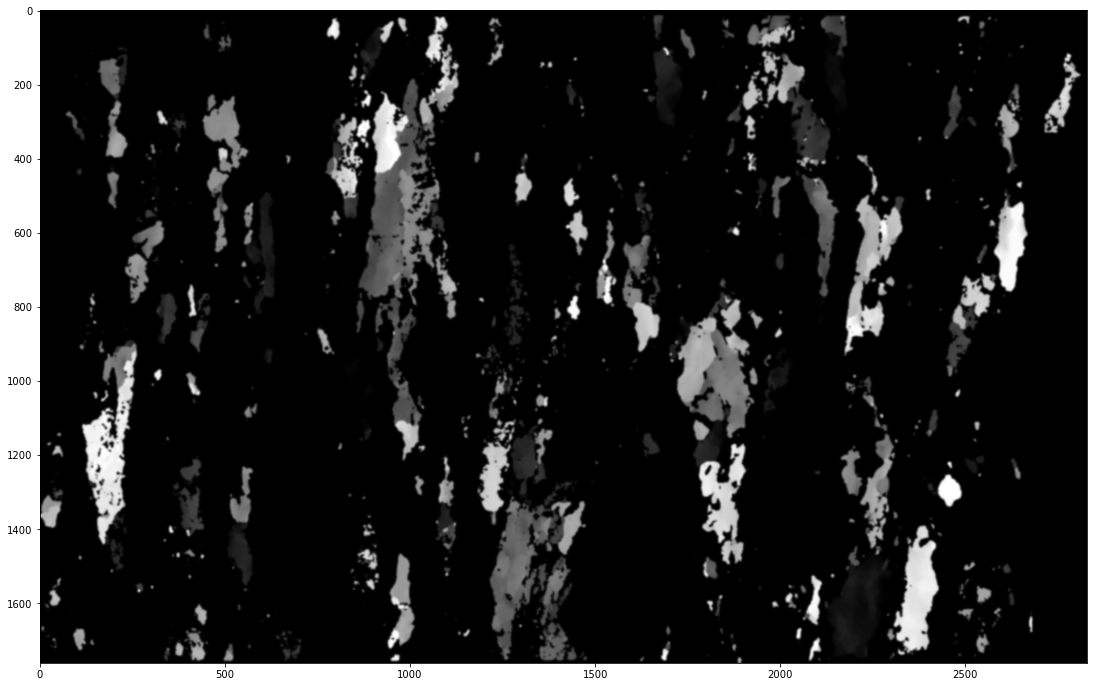

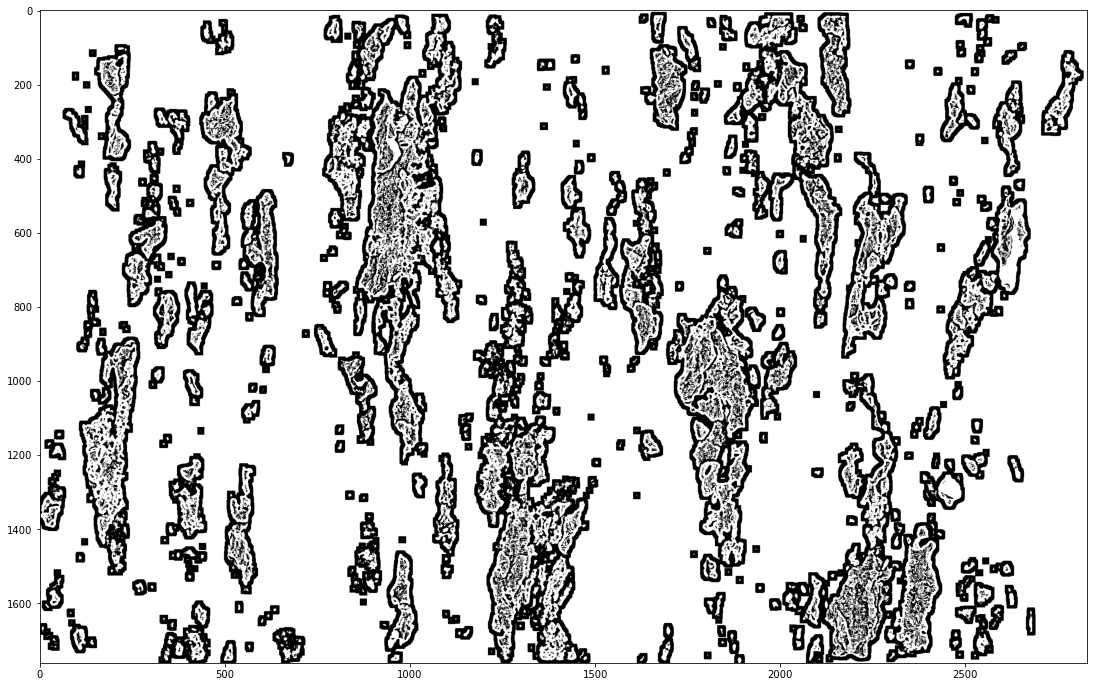

In [7]:
"""
Local Thresholding of rank_filtered: local_thresh
Blobs detected between rank_filtered and local_thresh: mask
"""
local_thresh = filters.threshold_local(rank_filtered, LT_BLOCK_SIZE)
mask = rank_filtered > local_thresh

print(f"local_thresh: {local_thresh.shape} {local_thresh.dtype}")
print(f"mask: {mask.shape} {mask.dtype}")

if SHOW_IMAGES:
    fig, axs = plt.subplots(1, figsize=(24, 12))
    axs.imshow(local_thresh, cmap='gray')
    fig, axs = plt.subplots(1, figsize=(24, 12))
    axs.imshow(mask, cmap='gray')


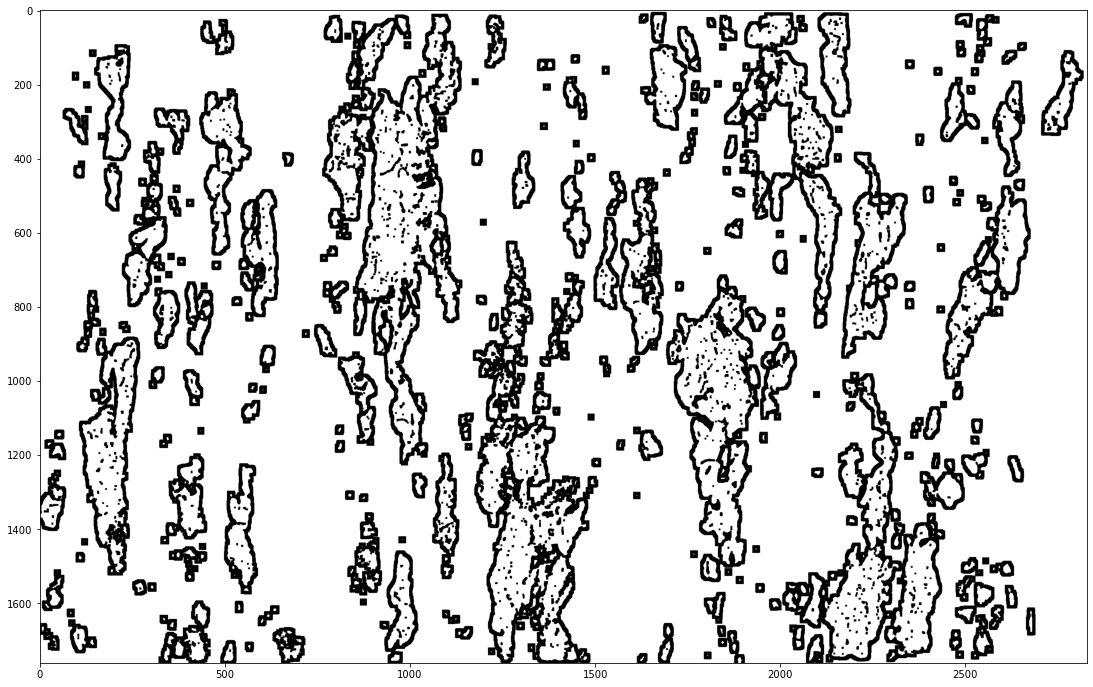

In [10]:
# NOTE: interesting effect on previous mask image?

closed = morphology.closing(mask, morphology.square(5))

fig, axs = plt.subplots(1, figsize=(24, 12))
axs.imshow(closed, cmap='gray')


In [7]:
# SKIMAGE EXAMPLE METHOD
#
# NOTE: image is an extremely clean binary image
# distance = ndimage.distance_transform_edt(image)
#
# local_maxi = feature.peak_local_max(distance, indices = False, footprint=np.ones((3, 3)), labels=image)
#
# markers = morphology.label(local_maxi)
#
# labels_ws = segmentation.watershed(-distance, markers, mask=image)
#


In [8]:
# GILL COINS METHOD
#
# NOTE: thresh uses GLOBAL thresholding
# thresh = filters.threshold_otsu(coins)
# mask = coins > thresh
#
# NOTE: this removes that big white glare from the upper right corner of the coins image
clean_border = segmentation.clear_border(mask)
#
# NOTE: this removes remaining white dots from black background, but doesn't seem to mess with insides of coins
remove_small = morphology.remove_small_objects(clean_border)
#
# NOTE: this clears up black spots inside the coin's GRAIN BOUNDARIES
# SECRET SAUCE?
closed = morphology.closing(remove_small, morphology.square(5))
#
# NOTE: glowing green topographical figures
distance = ndi.distance_transform_edt(closed)
#
# NOTE: dots at highest points of green topo features
local_maxi = feature.peak_local_max(distance, indices = False, footprint=np.ones((15, 15)), labels=closed)
#
# NOTE: transforms local maxi dots into actual LABELS
markers = morphology.label(local_maxi) #connected component labeling
#
labels_ws = skimage.segmentation.watershed(-distance, markers, mask=closed)
#


/tmp/ipykernel_6491/4061532243.py:21: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = feature.peak_local_max(distance, indices = False, footprint=np.ones((15, 15)), labels=closed)


NameError: name 'skimage' is not defined

In [ ]:
# EDGE BASED SEGMENTATION
#
# NOTE: this nearly knocks out all background pollution of the coins and black dots inside grains,
#       but leaves one coin looking 'canny' inside grain boundary
# edges = feature.canny(coins)
# fill_coins = ndi.binary_fill_holes(edges)
#
# NOTE: canny looking coin doesn't survive
# coins_cleaned = morphology.remove_small_objects(fill_coins, 21)
#


In [ ]:
# REGION BASED SEGMENTATION
#
# NOTE: looks a lot line canny, but less skeletal.... smoother. white rings at near grain boundaries
# elevation_map = filters.sobel(coins)
#
# NOTE: looks like shit, but recall that you can densify or sparsen the number of markers
# markers = np.zeros_like(coins)
# markers[coins < 30] = 1
# markers[coins > 150] = 2
#
# NOTE: Pretty decent mask. BINARY IMAGE. few holes in the problem coin (the one that remained canny in edge-based example)
# segmentation_coins = segmentation.watershed(elevation_map, markers)
#
#
# NOTE: filling holes after watershed,
# NOTE: Using ndi.label on watershed binary image instead of morphology.label on local maxi dots.
#       Getting entire coins as labels instead of little dots.
# NOTE: Label RGB turns up the rainbow
# segmentation_coins = ndi.binary_fill_holes(segmentation_coins - 1)
# labeled_coins, _ = ndi.label(segmentation_coins)
# image_label_overlay = color.label2rgb(labeled_coins, image=coins, bg_label=0)
#
#
# NOTE: The contour method puts this magical yellow ring around coins, and seems to impact image_label_overlay as well?
#       NOTE ASK GILL
# fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
# axes[0].imshow(coins, cmap=plt.cm.gray)
# axes[0].contour(segmentation_coins, [0.5], linewidths=1.2, colors='y')
# axes[1].imshow(image_label_overlay)
#
# for a in axes:
#     a.axis('off')
#
# plt.tight_layout()
#
# plt.show()
#
